In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import sys
from utils.metrics import quadratic_weighted_kappa
from utils.variables import search_space_xgb, search_space_lgbm, search_space_catboost, search_space_rf, search_space_logistic, search_knn, search_space_SVC
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from warnings import filterwarnings

filterwarnings('ignore')

/Data/victor.zhuang/Code/MIT/env/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
dict_models = {
    'xgb': {"model": xgb.XGBClassifier, "search_space": search_space_xgb},
    'lgbm': {"model": LGBMClassifier, "search_space": search_space_lgbm},
    'catboost': {"model": CatBoostClassifier, "search_space": search_space_catboost},
    'rf': {"model": RandomForestClassifier, "search_space": search_space_rf},
}

In [3]:
train_path = "training_sets/imputed_train_optimal_knn.csv"

# read the data
train = pd.read_csv(train_path)
# train = train.drop("PreInt_EduHx-Season.1", axis=1)

# List of columns to impute (categorical variables that were not imputed in our soft impute preprocessing)
to_impute = ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
            'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone',
            'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num']

# Impute each column with its most common class
for column in to_impute:
    if column in train.columns:
        most_common_class = train[column].mode()[0]  # Get the most frequent value
        train[column].fillna(most_common_class, inplace=True)

# read the time series data
ts = pd.read_csv("time_series_extraction/ts_extract_train_merged.csv")
ts["id"] = ts["kid_id"]
ts = ts.drop(columns=["kid_id", "index"])

# Merge the time series data with the covariates
train = pd.merge(train, ts, on="id", how="left")

# preprocessing (one hot encoding of categorical variables)
cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
        'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']
pciat = train.columns[train.columns.str.startswith('PCIAT-PCIAT')].tolist() + ['sii', "PCIAT-Season"]

train_clean = pd.concat([train, pd.get_dummies(train[cat_c]).astype(int)], axis=1)
to_drop = ["id"] + cat_c
train_clean = train_clean.drop(to_drop, axis=1)
train_clean = train_clean.dropna(subset=pciat)

In [4]:
# Split the data into train, val and test
x_train, x_test, y_train, y_test = train_test_split(train_clean.drop(pciat, axis=1), train_clean['sii'], test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [5]:
results = []
best_models = {}
losses = {}

In [6]:
# Training loop
for clf in dict_models.keys():

    print("Training model: ", clf)

    l_train = []
    l_val = []

    clf_model = dict_models[clf]['model']
    search_space = dict_models[clf]['search_space']

    def objective(params):
        """
        Objective function for optimizing a classifier model.
        This function trains a classifier model with the given parameters, 
        makes predictions on the validation set, and calculates the 
        quadratic weighted kappa score as the evaluation metric.
        Args:
            params (dict): Dictionary of parameters to be used for the classifier model.
        Returns:
            dict: A dictionary containing the negative quadratic weighted kappa score 
                    as 'loss' and the status 'STATUS_OK'.
        """

        if clf=="lgbm":
            params["verbose"] = -1
        if clf=="catboost":
            params["verbose"] = 0

        model = clf_model(**params)
        model.fit(x_train.to_numpy(), y_train.to_numpy())

        y_pred = model.predict(x_val.to_numpy())

        # keep track of the loss
        score = cohen_kappa_score(y_val, y_pred, weights='quadratic')
        score_train = cohen_kappa_score(y_train, model.predict(x_train.to_numpy()), weights='quadratic')
        l_train.append(score_train)
        l_val.append(score)

        return {'loss': -score, 'status': STATUS_OK}
    
    # Fine Tuning model
    trials = Trials()

    best_params = fmin(
    fn=objective,  # Objective function
    space=search_space,  # Hyperparameter search space
    algo=tpe.suggest,  # Tree-structured Parzen Estimator
    max_evals=50,  # Number of iterations
    trials=trials,  # Store trial results
    rstate=np.random.default_rng(42)  # For reproducibility
    )

    if clf == "rf":
        best_params["n_estimators"] = int(best_params["n_estimators"])
        best_params["max_depth"] = int(best_params["max_depth"])

    if clf == "catboost":
        best_params["verbose"] = 0

    if clf == "xgb":
        best_params["max_depth"] = int(best_params["max_depth"])
        best_params["n_estimators"] = int(best_params["n_estimators"])

    if clf == "lgbm":
        best_params["max_depth"] = int(best_params["max_depth"])
        best_params["n_estimators"] = int(best_params["n_estimators"])


    if clf == "knn":
        best_params["n_neighbors"] = int(best_params["n_neighbors"])

    # Train the model
    model = clf_model(**best_params)
    model.fit(x_train.to_numpy(), y_train.to_numpy())

    # Predict on the test set
    y_pred_test = model.predict(x_test.to_numpy())
    y_pred_val = model.predict(x_val.to_numpy())
    y_pred_train = model.predict(x_train.to_numpy())

    # results.append(pd.DataFrame(index = [clf], data = {'QWK': [cohen_kappa_score(y_test, y_pred, weights='quadratic')], 'params': [best_params], "Accuracy": [model.score(x_test.to_numpy(), y_test.to_numpy())]}))
    results.append(pd.DataFrame(index = [clf], data = {'QWK_test': [cohen_kappa_score(y_test, y_pred_test, weights='quadratic')], 
                                                        "QWK_val": [cohen_kappa_score(y_val, y_pred_val, weights='quadratic')], 
                                                        "QWK_train": [cohen_kappa_score(y_train, y_pred_train, weights='quadratic')],
                                                        'acc_test': [model.score(x_test.to_numpy(), y_test.to_numpy())],
                                                        'acc_val': [model.score(x_val.to_numpy(), y_val.to_numpy())],
                                                        'acc_train': [model.score(x_train.to_numpy(), y_train.to_numpy())],
                                                        'params': [best_params]}))
    
    best_models[clf] = model

    losses[clf] = {"train": l_train, "val": l_val}

Training model:  xgb
100%|██████████| 50/50 [14:10<00:00, 17.02s/trial, best loss: -0.42309728975111927]  
Training model:  lgbm
100%|██████████| 50/50 [00:51<00:00,  1.02s/trial, best loss: -0.42289013718864] 
Training model:  catboost
100%|██████████| 50/50 [09:08<00:00, 10.97s/trial, best loss: -0.446737204960023] 
Training model:  rf
100%|██████████| 50/50 [07:02<00:00,  8.45s/trial, best loss: -0.43000656758531774]


In [7]:
results = pd.concat(results)
display(results)

,QWK_test,QWK_val,QWK_train,acc_test,acc_val,acc_train,params
xgb,0.331674,0.423097,0.912752,0.629907,0.670561,0.946721,"{'colsample_bytree': 0.8270678831922279, 'lear..."
lgbm,0.362535,0.422890,1.000000,0.620561,0.633178,1.000000,"{'learning_rate': 0.08251323454296797, 'max_de..."
catboost,0.332733,0.446737,0.507267,0.622430,0.642523,0.741218,"{'depth': 4.0, 'iterations': 160.0, 'learning_..."
rf,0.332439,0.406518,0.841532,0.635514,0.661215,0.912763,"{'max_depth': 9, 'max_features': 0.83611039175..."


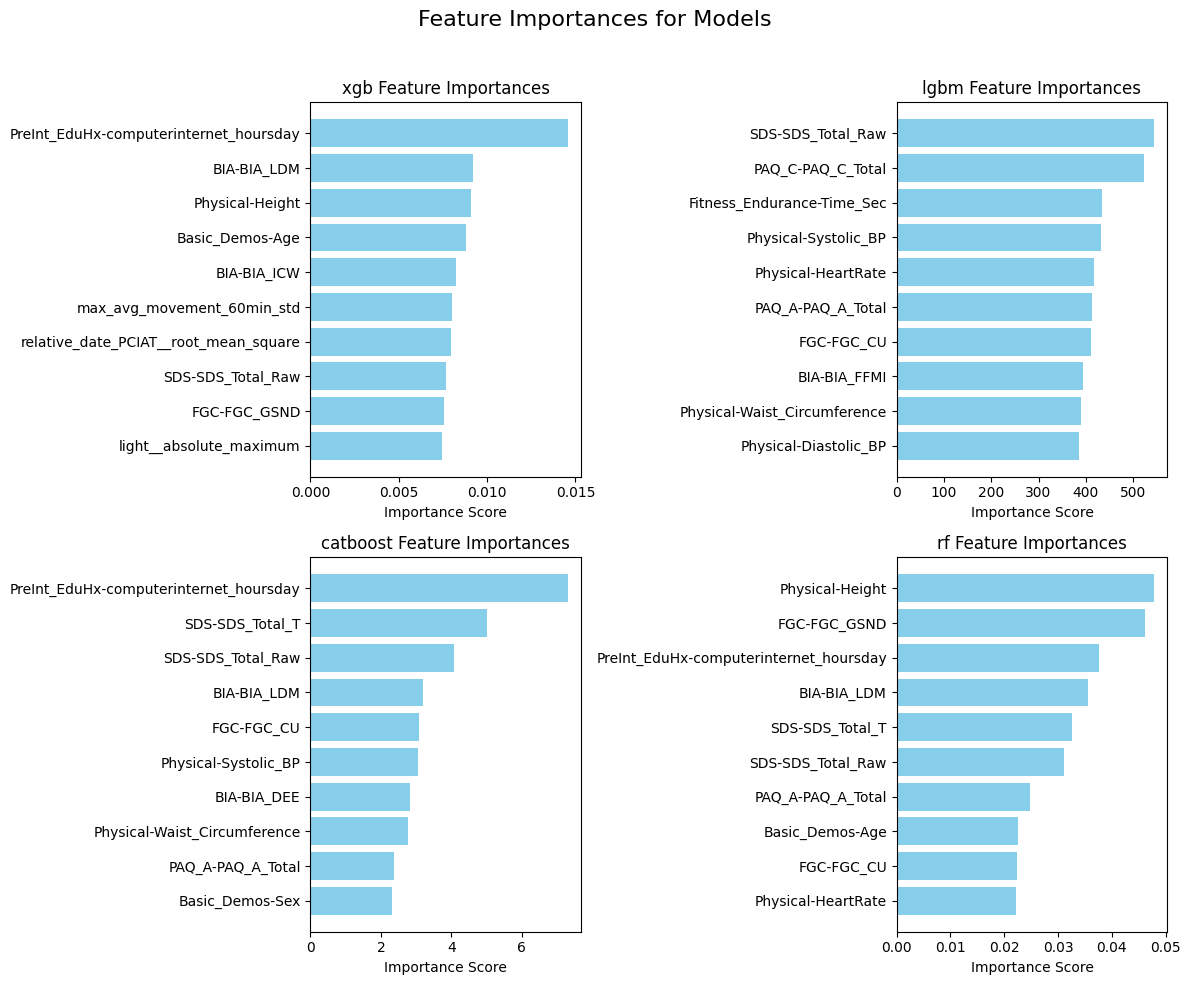

In [ ]:
# Feature importance
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Function to visualize feature importances for models
def plot_feature_importances(models, feature_names):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Feature Importances for Models', fontsize=16)

    axes = axes.flatten()

    for idx, (clf, model) in enumerate(models.items()):
        if idx >= len(axes):
            break

        # Check if model has feature importance attribute
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "coef_"):
            importances = np.abs(model.coef_).flatten()
        else:
            axes[idx].text(0.5, 0.5, "No Feature Importances", 
                           ha='center', va='center', fontsize=12)
            axes[idx].set_title(f'{clf} Feature Importances')
            axes[idx].axis('off')
            continue

        sorted_idx = np.argsort(importances)[::-1]
        sorted_importances = importances[sorted_idx]
        sorted_features = [feature_names[i] for i in sorted_idx]

        axes[idx].barh(sorted_features[:10], sorted_importances[:10], color='skyblue')
        axes[idx].invert_yaxis()
        axes[idx].set_title(f'{clf} Feature Importances')
        axes[idx].set_xlabel('Importance Score')

    # Hide unused subplots if fewer than 4 models
    for i in range(len(models), len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Assuming 'best_models' dictionary and 'feature_names' are defined
feature_names = x_train.columns.tolist()  # Update with your feature names
plot_feature_importances(best_models, feature_names)

What's interesting here is that all the models do not consider the same variables are important.

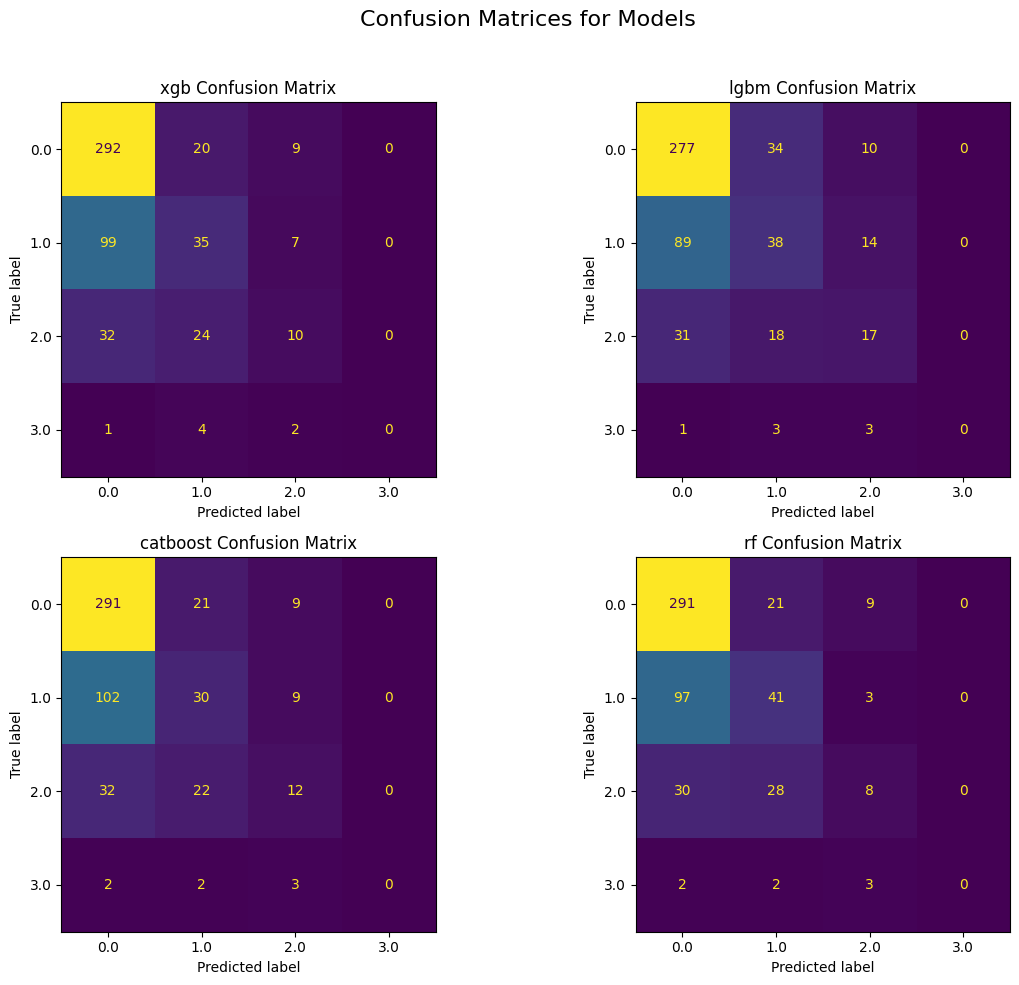

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to visualize confusion matrices for models
def plot_confusion_matrices(models, x_test, y_test):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Confusion Matrices for Models', fontsize=16)

    axes = axes.flatten()

    for idx, (clf, model) in enumerate(models.items()):
        if idx >= len(axes):
            break

        # Generate predictions
        y_pred = model.predict(x_test)

        # Plot confusion matrix
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[idx], colorbar=False)
        axes[idx].set_title(f'{clf} Confusion Matrix')

    # Hide unused subplots if fewer than 4 models
    for i in range(len(models), len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Assuming 'best_models' dictionary, 'x_test', and 'y_test' are defined
plot_confusion_matrices(best_models, x_test, y_test)
